### Installation

In [ ]:
! pip install --quiet "pytorch-lightning"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 10.7 MB/s eta 0:00:00


### Import dependencies


In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import FashionMNIST
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers.csv_logs import CSVLogger
import torch.nn.functional as F
from PIL import Image
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import platform

print("Lightning version:", pl.__version__)
print("PyTorch version:", torch.__version__)
print("Python version:", platform.python_version())

Lightning version: 2.0.7
PyTorch version: 2.0.1+cu118
Python version: 3.10.12


### Reproducibility

In [ ]:
pl.seed_everything(42)

NameError: ignored

-------------------------------------------
### Manual Dataset Loading

In [ ]:
class Rotation3:
    def __call__(self, img):
        # Randomly rotate the images by 90, 180, or 270 degrees
        angle = random.choice([0, 90, 180, 270])
        img = T.functional.rotate(img, angle)
        return img

samples = 16
data_transforms = {
    'train': T.Compose([T.Resize((32, 32)),                  # resizing
                        T.RandomVerticalFlip(),              # Flip images vertically with a certain probability
                        T.RandomHorizontalFlip(),            # Flip images horizontally with a certain probability
                        T.RandomCrop(30),                    # Randomly crop the images by 0-2 pixels from their boundary
                        T.Grayscale(1),                      # 1 Grayscale -> 3 RGB channel
                        T.Resize((32, 32)),                  # resized after crop
                        T.RandomApply([Rotation3()], p=1),   #randomly rotate
                        T.ToTensor(),
                        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': T.Compose([T.Resize(32),
                       T.Grayscale(1),
                       T.ToTensor(),
                       T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'display': T.Compose([T.Resize(32),
                          T.Grayscale(1),
                          T.ToTensor(),
                          T.Normalize([0.5], [0.5])
    ])
}

#Load data train and test
trainset = FashionMNIST(root='./data', train=True,
                        download=True, transform=data_transforms['train'])
print('Trainset:', len(trainset))

displayset = FashionMNIST(root='./data', train=True,
                        download=True, transform=data_transforms['display'])

testset = FashionMNIST(root='./data', train=False,
                       download=True,transform=data_transforms['test'])
print('Testset:', len(testset))

#Prepare validation
indices = list(range(len(trainset)))
#np.random.shuffle(devices)

split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data loader
trainloader = DataLoader(trainset, batch_size = samples, shuffle = False, num_workers = 2)
testloader = DataLoader(testset, batch_size = samples, shuffle = True, num_workers = 2)
valloader = DataLoader(trainset, batch_size = samples, shuffle = False, num_workers = 2)
displayloader = DataLoader(displayset, batch_size = samples, shuffle = False, num_workers = 2)



Trainset: 60000
Testset: 10000


### Dataset Exploration

In [ ]:
# Define a dictionary mapping class indices to class names
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [ ]:
# Create a dictionary to store class counts
class_counts = defaultdict(int)

# Iterate through the dataset and count samples for each class
for _, labels in trainloader:
    for label in labels:
        class_counts[label.item()] += 1

# Print the class counts along with class names in an ordered way
for class_label, count in sorted(class_counts.items()):
    class_name = class_names[class_label]
    print(f"Class {class_label} ({class_name}): {count} samples")

RuntimeError: ignored

Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])
Image shape: torch.Size([1, 32, 32])


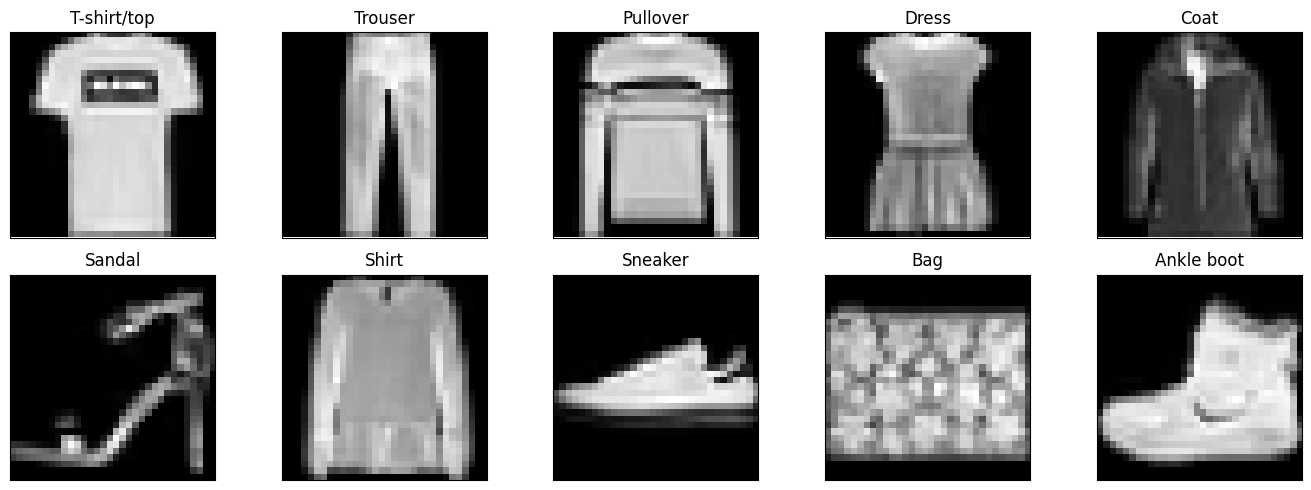

In [ ]:
# Create a dictionary to store class indices and their corresponding images
class_images = defaultdict(list)

# Iterate through the display loader and collect one image per class
display_iter = iter(displayloader)
for images, labels in display_iter:
    for image, label in zip(images, labels):
        class_images[label.item()].append(image)
        if len(class_images) == 10:  # Break once we have an image for each class
            break

# Create a figure to display the sample images
fig = plt.figure(figsize=(15, 5))

# Iterate through the collected images and display them
for class_label, images in class_images.items():
    ax = fig.add_subplot(2, 5, class_label + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[0]), cmap='gray')
    ax.set_title(class_names[class_label])  # Use class names from the dictionary

    print(f"Image shape: {images[0].shape}")

    fig.tight_layout()

plt.show()


### Data Loading

FashionMNIST dataset loading and augmentation according to the SOTA implementation requirements

In [2]:
class DataModule(pl.LightningDataModule):

    def __init__(self, batch_size, data_dir: str = "./"):
        super().__init__()

        class Rotation3:
            def __call__(self, img):
                # Randomly rotate the images by 90, 180, or 270 degrees
                angle = random.choice([0, 90, 180, 270])
                img = T.functional.rotate(img, angle)
                return img

        self.data_dir = data_dir
        self.transform = {
                          'train': T.Compose([
                              T.Resize((32)),
                              T.RandomVerticalFlip(),
                              T.RandomHorizontalFlip(),
                              T.RandomCrop(30),
                              T.Resize(32),
                              T.Grayscale(1),  # Use 1 channel (grayscale)
                              T.Resize(32),
                              T.RandomApply([Rotation3()], p=1),
                              T.Resize(32),
                              T.ToTensor(),
                              T.Normalize([0.5], [0.5])
                          ]),
                          'test': T.Compose([
                              T.Resize(32),
                              T.Grayscale(1),  # Use 1 channel (grayscale)
                              T.Resize(32),
                              T.ToTensor(),
                              T.Normalize([0.5], [0.5])
                          ]),
                          'display': T.Compose([
                              T.Resize(32),
                              T.Grayscale(1),
                              T.ToTensor(),
                              T.Normalize([0.5], [0.5])
                          ])
                      }

        #self.dims = (3, 32, 32)
        self.num_classes = 10
        self.batch_size = batch_size

    def prepare_data(self):
        # download
        FashionMNIST(root=self.data_dir, train=True, download=True, transform=self.transform['train'])
        FashionMNIST(root=self.data_dir, train=False, download=True,transform=self.transform['test'])

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            # Define the transformations, train and validation datasets, and samplers here
            full_dataset = FashionMNIST(root='./data', train=True, download=True, transform=self.transforms['train'])

            indices = list(range(len(full_dataset)))
            split = int(np.floor(0.2 * len(full_dataset)))

            self.train_sampler = SubsetRandomSampler(indices[:split])
            self.valid_sampler = SubsetRandomSampler(indices[split:])

            self.train_dataset = torch.utils.data.Subset(full_dataset, indices[:split])
            self.valid_dataset = torch.utils.data.Subset(full_dataset, indices[split:])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.test_dataset = FashionMNIST(self.data_dir, train=False, download=True,transform=self.transform['test'])
        if stage == "predict" or stage is None:
            self.test_dataset = FashionMNIST(self.data_dir, train=False, download=True,transform=self.transform['test'])

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return  torch.utils.data.DataLoader(self.valid_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return  torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)

    def predict_dataloader(self):
        return  torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)



NameError: name 'pl' is not defined

In [ ]:
#import sklearn
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

class BalancedDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir="./", num_clusters=10):
        super().__init__()

        self.num_clusters = num_clusters

        class Rotation3:
            def __call__(self, img):
                # Randomly rotate the images by 90, 180, or 270 degrees
                angle = random.choice([0, 90, 180, 270])
                img = T.functional.rotate(img, angle)
                return img

        self.data_dir = data_dir
        self.transform = {
                          'train': T.Compose([
                              T.Resize((32)),
                              T.RandomVerticalFlip(),
                              T.RandomHorizontalFlip(),
                              T.RandomCrop(30),
                              T.Resize(32),
                              T.Grayscale(1),  # Use 1 channel (grayscale)
                              T.Resize(32),
                              T.RandomApply([Rotation3()], p=1),
                              T.Resize(32),
                              T.ToTensor(),
                              T.Normalize([0.5], [0.5])
                          ]),
                          'test': T.Compose([
                              T.Resize(32),
                              T.Grayscale(1),  # Use 1 channel (grayscale)
                              T.Resize(32),
                              T.ToTensor(),
                              T.Normalize([0.5], [0.5])
                          ]),
                          'display': T.Compose([
                              T.Resize(32),
                              T.Grayscale(1),
                              T.ToTensor(),
                              T.Normalize([0.5], [0.5])
                          ])
                      }
        self.num_classes = 2
        self.batch_size = batch_size

    def prepare_data(self):
        # Download and preprocess the data
        full_dataset = FashionMNIST(root=self.data_dir, train=True, download=True, transform=self.transform['train'])
        self.full_dataset = full_dataset

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            # K-means clustering
            all_data = [self.full_dataset[i][0].numpy().flatten() for i in range(len(self.full_dataset))]
            kmeans = KMeans(n_clusters=self.num_clusters, random_state=0).fit(all_data)
            cluster_indices = defaultdict(list)
            for idx, label in enumerate(kmeans.labels_):
                cluster_indices[label].append(idx)

            normal_class = 0  # Define a class as normal
            self.train_dataset = []
            self.valid_dataset = []
            for cls in range(self.num_classes):
                if cls == normal_class:
                    # Use all data for the normal class
                    indices = cluster_indices[cls]
                else:
                    # Sample the same number of data from each cluster for anomaly classes
                    sampled_indices = shuffle(cluster_indices[cls], random_state=0)[:len(cluster_indices[normal_class])]
                    indices = sampled_indices

                split = int(np.floor(0.2 * len(indices)))
                self.train_sampler = SubsetRandomSampler(indices[:split])
                self.valid_sampler = SubsetRandomSampler(indices[split:])

                self.train_dataset.extend(torch.utils.data.Subset(self.full_dataset, indices[:split]))
                self.valid_dataset.extend(torch.utils.data.Subset(self.full_dataset, indices[split:]))
                normal_class += 1

        if stage == "test" or stage is None:
            self.test_dataset = FashionMNIST(self.data_dir, train=False, download=True, transform=self.transform['test'])

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return  torch.utils.data.DataLoader(self.valid_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return  torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)

    def predict_dataloader(self):
        return  torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)


### Simple Model FC

In [ ]:
class PrintAccuracyAndLoss(pl.Callback):
    def on_epoch_end(self, trainer, pl_module):
        train_acc = pl_module.train_acc.compute()
        val_acc = pl_module.val_acc.compute()
        train_loss = trainer.callback__metrics['train_loss']
        val_loss = trainer.callback__metrics['val_loss']

        print(f"Epoch {trainer.current_epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")


class SimpleCNNModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.l1 = torch.nn.Linear(32 * 16 * 16, 2)

    def forward(self, x):
        # Convolution
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)

        # FC
        x = x.view(x.size(0), -1)
        x = self.l1(x)
        x = torch.relu(x)
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        pred = self(x)
        #loss = F.cross_entropy(pred, y)
        loss = F.mse_loss(pred, y)
        acc = (pred.argmax(dim=-1) == y).float().mean()

        self.log("train_acc", acc, on_step=True, on_epoch=True)
        self.log("train Loss:", loss)

        return loss

    def validation_step(self, batch, batch_nb):
        x, y = batch
        pred = self(x)
        #loss = F.cross_entropy(pred, y)
        loss = F.mse_loss(pred, y)
        acc = (pred.argmax(dim=-1) == y).float().mean()

        self.log("valid_acc", acc, on_step=True, on_epoch=True)
        self.log("valid Loss:", loss)

        return loss

    def test_step(self, batch, batch_nb):
        x, y = batch
        pred = self(x)
        #loss = F.cross_entropy(pred, y)
        loss = F.mse_loss(pred, y)
        acc = (pred.argmax(dim=-1) == y).float().mean()

        self.log("test_acc", acc, on_step=True, on_epoch=True)
        self.log("test Loss:", loss)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)


## **Training**

### Train 10 classes

In [ ]:
dm = DataModule(128)

model = SimpleCNNModel()
trainer = pl.Trainer(max_epochs=2,
                     #logger=logger,
                     callbacks=[TQDMProgressBar(refresh_rate=20),
                                PrintAccuracyAndLoss(),
                                EarlyStopping(monitor="valid_acc", patience=3)],)  #`train_acc`, `train_acc_step`, `Train Loss:`, `Valid_acc`, `Valid_acc_epoch`, `Valid Loss:`, `train_acc_epoch`
res = trainer.fit(model, dm)
#trainer.fit(model, trainloader, valloader)
#trainer.fit(model, trainloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 26421880/26421880 [00:01<00:00, 17440219.29it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300957.32it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5598243.14it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18298539.82it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:01<00:00, 16431275.81it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302767.29it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5598690.95it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8138815.30it/s]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 320   
1 | l1    | Linear | 16.4 K
---------------------------------
16.7 K    Trainable params
0         Non-trainable params
16.7 K    Total params
0.067     Total estimated model params size (MB)


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Sanity Checking: 0it [00:00, ?it/s]

IndexError: ignored

In [ ]:
res = trainer.validate(model, datamodule=dm)
#print(res)

#model = MNISTModel()
res = trainer.test(model, datamodule=dm)
#print(res)

### Train 2 classes

In [ ]:
balanced_dm = BalancedDataModule(batch_size=128)
#balanced_dm.prepare_data()
#balanced_dm.setup()

model = SimpleCNNModel()
trainer = pl.Trainer(max_epochs=2,
                     #logger=logger,
                     callbacks=[TQDMProgressBar(refresh_rate=20),
                                PrintAccuracyAndLoss(),
                                EarlyStopping(monitor="valid_acc", patience=3)],)  #`train_acc`, `train_acc_step`, `Train Loss:`, `Valid_acc`, `Valid_acc_epoch`, `Valid Loss:`, `train_acc_epoch`

res = trainer.fit(model, balanced_dm)
res = trainer.test(model, datamodule=balanced_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\espda\AppData\Local\Programs\Python\Python37\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:68: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  "Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning`"


RuntimeError: The `Callback.on_epoch_end` hook was removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.

## DataModule

In [1]:
#!pip install --quiet "pytorch-lightning"

import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.datasets
import torchvision.transforms as T
from torchvision.datasets import FashionMNIST
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.cluster import KMeans

# Set float32 matrix multiplication precision for better performance
#torch.set_float32_matmul_precision('medium')  # or 'high' if desired


class Rotation3:
    def __call__(self, img):
        # Randomly rotate the images by 90, 180, or 270 degrees
        angle = random.choice([0, 90, 180, 270])
        img = T.functional.rotate(img, angle)
        return img

class AnomalyDetectionDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, subsampling, subsamples, data_dir="./"):
        super().__init__()


        self.transform = T.Compose([
            T.Resize((32, 32)),
            T.Grayscale(1),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])
        self.train_transform = T.Compose([
                                          T.Resize(32),
                                          T.RandomVerticalFlip(),
                                          T.RandomHorizontalFlip(),
                                          T.RandomCrop(30),
                                          T.Resize(32),
                                          T.Grayscale(1),  # Use 1 channel (grayscale)
                                          T.RandomApply([Rotation3()], p=1),
                                          T.ToTensor(),
                                          T.Normalize([0.5], [0.5])
                                         ]),
        self.test_transform = T.Compose([
                                          T.Resize(32),
                                          T.Grayscale(1),  # Use 1 channel (grayscale)
                                          T.ToTensor(),
                                          T.Normalize([0.5], [0.5])
                                        ])

        self.data_dir = data_dir
        self.dataset_classes = 10
        self.num_classes = 2  # Normal and Anomaly
        self.batch_size = batch_size
        self.num_clusters = self.dataset_classes - 1
        self.subsamples = subsamples
        self.subsampling = subsampling


    def kmeans_sampling(self, dataset, class_idx, num_samples):
        indices = [i for i in range(len(dataset)) if dataset.targets[i] != class_idx]
        class_data = torch.stack([dataset[i][0] for i in indices])
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=0, n_init=1) #n_init = 9
        kmeans.fit(class_data.view(class_data.size(0), -1).numpy())
        cluster_assignments = kmeans.predict(class_data.view(class_data.size(0), -1).numpy())
        sampled_indices = []
        for cluster_idx in range(self.num_clusters):
            cluster_indices = np.where(cluster_assignments == cluster_idx)[0]
            num_samples_from_cluster = min(num_samples, len(cluster_indices))
            sampled_indices.extend(np.random.choice(cluster_indices, num_samples_from_cluster, replace=False))
        return [indices[idx] for idx in sampled_indices]

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            all_data = []
            all_labels = []

            for normal_class in range(self.dataset_classes):
                dataset = FashionMNIST(root=self.data_dir, train=True, download=True, transform=self.test_transform)

                normal_indices = [i for i in range(len(dataset)) if dataset.targets[i] == normal_class]
                if self.subsampling == True:
                    normal_indices = normal_indices[:self.subsamples]
                #anomaly_indices = [i for i in range(len(dataset)) if dataset.targets[i] != normal_class]
                anomaly_indices = self.kmeans_sampling(dataset, normal_class, num_samples=len(normal_indices))

                normal_labels = torch.zeros(len(normal_indices), dtype=torch.float32)
                anomaly_labels = torch.ones(len(anomaly_indices), dtype=torch.float32)

                all_data.extend([dataset[i][0] for i in normal_indices])
                all_data.extend([dataset[i][0] for i in anomaly_indices])
                all_labels.extend(normal_labels)
                all_labels.extend(anomaly_labels)

            all_data = torch.stack(all_data)
            all_labels = torch.tensor(all_labels)

            self.train_dataset = torch.utils.data.TensorDataset(all_data, all_labels)



        if stage == 'test' or stage is None:
            all_data = []
            all_labels = []

            for class_idx in range(self.dataset_classes):
                dataset = FashionMNIST(root=self.data_dir, train=False, download=True, transform=self.transform)
                normal_indices = [i for i in range(len(dataset)) if dataset.targets[i] == class_idx]
                anomaly_indices = [i for i in range(len(dataset)) if dataset.targets[i] != class_idx]

                normal_indices = normal_indices[:100]
                anomaly_indices = anomaly_indices[:100]

                normal_labels = torch.zeros(len(normal_indices), dtype=torch.float32)  # Set labels to Float data type
                anomaly_labels = torch.ones(len(anomaly_indices), dtype=torch.float32)  # Set labels to Float data type

                all_data.extend([dataset[i][0] for i in normal_indices])
                all_data.extend([dataset[i][0] for i in anomaly_indices])
                all_labels.extend(normal_labels)
                all_labels.extend(anomaly_labels)

            all_data = torch.stack(all_data)
            all_labels = torch.tensor(all_labels)

            self.test_dataset = torch.utils.data.TensorDataset(all_data, all_labels)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)





## Simple CNN

In [2]:
class SimpleCNNModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * 16 * 16, 1)  # Output a single value

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)

        #print("pred", pred.squeeze(), "shape:",pred.squeeze().shape, "|||    y", y.squeeze(), "shape:", y.shape)
        loss = F.mse_loss(pred.squeeze(), y.squeeze())  # Calculate mean squared error loss
        acc = (pred.round() == y).float().mean()

        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)

        loss = F.mse_loss(pred.squeeze(), y.squeeze())
        acc = (pred.round() == y).float().mean()

        self.log("test_loss", loss)
        self.log("test_acc", acc)

        # Calculate ROC-AUC
        y_prob = torch.sigmoid(pred.squeeze())  # Apply sigmoid to get probability scores
        roc_auc = roc_auc_score(y.cpu().numpy(), y_prob.cpu().numpy())

        self.log("roc_auc", roc_auc)

        return {"test_loss": loss, "test_acc": acc, "test_roc_auc": roc_auc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.002)


class SOTA(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * 16 * 16, 1)  # Output a single value

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



### Train and Test CNN

In [3]:
#Hyperparameters
BATCH_SIZE = 256
epochs = 1
subsamples = 100
accelerator_enabled = True

data_module = AnomalyDetectionDataModule(batch_size=256, subsamples=subsamples)
model = SimpleCNNModel()
#logger = TensorBoardLogger("tb_logs", name="net",log_graph=True )


if torch.cuda.is_available() and accelerator_enabled: 
  print("GPU")
  trainer = pl.Trainer(accelerator="cuda", max_epochs=epochs, callbacks=[TQDMProgressBar(), EarlyStopping(monitor="train_loss", patience=3)])
else : 
  print("CPU")
  trainer = pl.Trainer(accelerator="cpu", max_epochs=epochs, callbacks=[TQDMProgressBar(), EarlyStopping(monitor="train_loss", patience=3)])


trainer.fit(model, data_module)

# Testing
test_results = trainer.test(model, data_module)
print(test_results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


GPU


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 320   
1 | fc    | Linear | 8.2 K 
---------------------------------
8.5 K     Trainable params
0         Non-trainable params
8.5 K     Total params
0.034     Total estimated model params size (MB)
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower v

Epoch 0: 100%|██████████| 40/40 [00:01<00:00, 22.99it/s, v_num=19]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 40/40 [00:01<00:00, 22.91it/s, v_num=19]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 153.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          roc_auc          │    0.4822308863039413     │
│         test_acc          │            0.5            │
│         test_loss         │    0.43182921409606934    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.43182921409606934, 'test_acc': 0.5, 'roc_auc': 0.4822308863039413}]


In [4]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 17928), started 0:23:00 ago. (Use '!kill 17928' to kill it.)

## SOTA GAN-based

- **U-NET Structure**: Ronneberger, O., Fischer, P., Brox, T.: U-net: Convolutional networks for biomedical image segmentation. In: International Conference on Medical image computing
and computer-assisted intervention. pp. 234–241. Springer (2015)


In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        '''
        # Encoder
        self.enc_conv1 = self.conv_block(in_channels, 22)
        self.enc_conv2 = self.conv_block(22, 32)
        self.enc_conv3 = self.conv_block(32, 42)
        
        # Bottleneck
        self.bottleneck = self.conv_block(42, 50)
        
        # Decoder
        self.dec_conv1 = self.conv_block(50, 42, transpose=True)
        self.dec_conv2 = self.conv_block(42, 32, transpose=True)
        self.dec_conv3 = self.conv_block(32, 22, transpose=True)
        
        self.final_conv = self.conv_block(22, 1, transpose=True)
'''
        # Encoder
        self.enc_conv1 = self.conv_block(in_channels, 64)
        #self.enc_conv2 = self.conv_block(64, 128)
        #self.enc_conv3 = self.conv_block(128, 256)
        
        # Bottleneck
        #self.bottleneck = self.conv_block(256, 512)
        
        # Decoder
        #self.dec_conv1 = self.conv_block(512, 256, transpose=True)
        #self.dec_conv2 = self.conv_block(256, 128, transpose=True)
        #self.dec_conv3 = self.conv_block(128, 64, transpose=True)
        
        self.final_conv = self.conv_block(64, 1, transpose=True)


        print("GENERATOR:")
        self.print_parameter_count("Encoder Conv1", self.enc_conv1)
        #self.print_parameter_count("Encoder Conv2", self.enc_conv2)
        #self.print_parameter_count("Encoder Conv3", self.enc_conv3)
        #self.print_parameter_count("Bottleneck", self.bottleneck)
        #self.print_parameter_count("Decoder Conv1", self.dec_conv1)
        #self.print_parameter_count("Decoder Conv2", self.dec_conv2)
        #self.print_parameter_count("Decoder Conv3", self.dec_conv3)
        self.print_parameter_count("Final Conv", self.final_conv)

        
    def conv_block(self, in_channels, out_channels, transpose=False):
        if transpose:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                #nn.MaxPool2d(2, stride=2)
                #nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2),
                #nn.ReLU(inplace=True)
            )
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        #enc2 = self.enc_conv2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        #enc3 = self.enc_conv3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        
        # Bottleneck
        #bottleneck = self.bottleneck(F.max_pool2d(enc3,  kernel_size=2, stride=2))
        
        # Decoder
        #dec1 = F.interpolate(self.dec_conv1(bottleneck), scale_factor=2, mode='bilinear', align_corners=False)
        #dec2 = F.interpolate(self.dec_conv2(torch.cat([dec1, enc1], dim=1)), scale_factor=2, mode='bilinear', align_corners=False)
        
        #output = self.final_conv(dec2)
        output = self.final_conv(enc1)
        return output
    
    
    def print_parameter_count(self, name, module):
        num_params = sum(p.numel() for p in module.parameters())
        formatted_params = self.format_parameter_count(num_params)
        #print(f"{name} - Number of Parameters: {num_params}")
        print(f"{name} - Number of Parameters: {formatted_params}")
        
    def format_parameter_count(self, num_params):
        if num_params < 1e3:
            return f"{num_params:.2f}"
        elif num_params < 1e6:
            return f"{num_params / 1e3:.2f}K"
        elif num_params < 1e9:
            return f"{num_params / 1e6:.2f}M"
        else:
            return f"{num_params / 1e9:.2f}G"
        

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1_s2 = self.conv_block(1, 64, kernel_size=3, stride=2)
        #self.conv2_s2 = self.conv_block(22, 128, kernel_size=3, stride=2)
        #self.conv3_s2 = self.conv_block(128, 64, kernel_size=3, stride=2)
        #self.conv1_s1 = self.conv_block(64, 32, kernel_size=3, stride=1)
        self.conv2_s1 = self.conv_block(64, 1, kernel_size=3, stride=1)

        print("DISCRIMINATOR:")
        self.print_parameter_count("Conv1_s2", self.conv1_s2)
        #self.print_parameter_count("Conv2_s2", self.conv2_s2)
        #self.print_parameter_count("Conv3_s2", self.conv3_s2)
        #self.print_parameter_count("Conv1_s1", self.conv1_s1)
        self.print_parameter_count("Conv2_s1", self.conv2_s1)

    def forward(self, x):
        x = self.conv1_s2(x)
        #x = self.conv2_s2(x)
        #x = self.conv1_s1(x)
        x = self.conv2_s2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def conv_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
            nn.ReLU(inplace=True),
        )

    def print_parameter_count(self, name, module):
        num_params = sum(p.numel() for p in module.parameters())
        formatted_params = self.format_parameter_count(num_params)
        print(f"{name} - Number of Parameters: {num_params}")
        #print(f"{name} - Number of Parameters: {formatted_params}")
        
    def format_parameter_count(self, num_params):
        if num_params < 1e3:
            return f"{num_params:.2f}"
        elif num_params < 1e6:
            return f"{num_params / 1e3:.2f}K"
        elif num_params < 1e9:
            return f"{num_params / 1e6:.2f}M"
        else:
            return f"{num_params / 1e9:.2f}G"


# GAN Model
class GAN(pl.LightningModule):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator(1, 1)
        self.discriminator_normal = Discriminator()
        self.discriminator_anomaly = Discriminator()

        self.automatic_optimization = False

    def forward(self, x):
        return self.generator(x)


    def training_step(self, batch, batch_idx):
        real_images, _ = batch
        valid = torch.ones(real_images.size(0), 1)
        fake = torch.zeros(real_images.size(0), 1)

        z = torch.randn(real_images.size(0), 1, 1, 1)
        gen_images = self.generator(z)

        # Manually access optimizers
        opt_gen, opt_disc_normal, opt_disc_anomaly = self.optimizers()

        # Train Generator
        gen_loss = F.binary_cross_entropy(self.discriminator_normal(gen_images), valid)
        self.log("gen_loss", gen_loss, on_step=True, on_epoch=True)
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        # Train Discriminator (Normal)
        real_loss = F.binary_cross_entropy(self.discriminator_normal(real_images), valid)
        fake_loss = F.binary_cross_entropy(self.discriminator_normal(gen_images.detach()), fake)
        
        #LSGAN Discriminator Loss
        disc_loss_normal = (real_loss + fake_loss) / 2
        self.log("disc_loss_normal", disc_loss_normal, on_step=True, on_epoch=True)
        opt_disc_normal.zero_grad()
        disc_loss_normal.backward()
        opt_disc_normal.step()

        # Train Discriminator (Anomaly)
        real_loss = F.binary_cross_entropy(self.discriminator_anomaly(real_images), valid)
        fake_loss = F.binary_cross_entropy(self.discriminator_anomaly(gen_images.detach()), fake)
        disc_loss_anomaly = (real_loss + fake_loss) / 2
        self.log("disc_loss_anomaly", disc_loss_anomaly, on_step=True, on_epoch=True)
        opt_disc_anomaly.zero_grad()
        disc_loss_anomaly.backward()
        opt_disc_anomaly.step()

        return {"gen_loss": gen_loss, "disc_loss_normal": disc_loss_normal, "disc_loss_anomaly": disc_loss_anomaly}

    def test_step(self, batch, batch_idx):
        real_images, _ = batch
        z = torch.randn(real_images.size(0), 1, 1, 1)
        gen_images = self.generator(z)

        # Calculate any metrics you need for testing
        # For example, you can use FID or any other appropriate metrics

        return {"gen_images": gen_images}

    def test_epoch_end(self, outputs):
        # Calculate aggregate metrics from test_step results
        # For example, calculate the average FID over the test dataset

        #avg_fid = calculate_average_fid(outputs)  # Replace with your actual metric calculation

        #self.log("avg_fid", avg_fid, on_epoch=True)
        self.log("avg_fid")

    def configure_optimizers(self):
        opt_gen = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_disc_normal = torch.optim.Adam(self.discriminator_normal.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_disc_anomaly = torch.optim.Adam(self.discriminator_anomaly.parameters(), lr=0.0002, betas=(0.5, 0.999))
        return [opt_gen, opt_disc_normal, opt_disc_anomaly]

### Train and Test SOTA

In [3]:
#Hyperparameters
BATCH_SIZE = 10
epochs = 1
subsampling = True
subsamples = 10
accelerator_enabled = True

data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE, 
                                         subsampling=subsampling, 
                                         subsamples=subsamples)
model = GAN()
#logger = TensorBoardLogger("tb_logs", name="net",log_graph=True )


if torch.cuda.is_available() and accelerator_enabled: 
  print("GPU")
  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(), EarlyStopping(monitor="train_loss", patience=3)]
                       )
else : 
  print("CPU")
  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs, 
                       callbacks=[TQDMProgressBar(), EarlyStopping(monitor="train_loss", patience=3)]
                       )


trainer.fit(model, data_module)

# Testing
test_results = trainer.test(model, data_module)
print(test_results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GENERATOR:
Encoder Conv1 - Number of Parameters: 1.09K
Final Conv - Number of Parameters: 1.02K
DISCRIMINATOR:
Conv1_s2 - Number of Parameters: 640
Conv2_s1 - Number of Parameters: 577
DISCRIMINATOR:
Conv1_s2 - Number of Parameters: 640
Conv2_s1 - Number of Parameters: 577
GPU


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type          | Params
--------------------------------------------------------
0 | generator             | Generator     | 2.1 K 
1 | discriminator_normal  | Discriminator | 1.2 K 
2 | discriminator_anomaly | Discriminator | 1.2 K 
--------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: P

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s] 

RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

In [ ]:
import torch
def assign_device(gpu):
    if (torch.cuda.is_available() and gpu==True):
        device = "cuda"
        print("Cuda enabled: using GPU")
    else:
        device = "cpu"
        print("Cuda not available: using CPU")
    return device

In [ ]:
import platform
device = assign_device(True)
#print("Lightning version:", pl.__version__)
print("PyTorch version:", torch.__version__)
print("Python version:", platform.python_version())

Cuda enabled: using GPU
PyTorch version: 2.0.1+cu118
Python version: 3.10.8
